In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-assignment-cl-ii-lab-task2-part1/euroSAT_train_val_test.pkl


# Importing the libraries

In [2]:
import os
import copy
import torch
import pickle
import random
import numpy as np
import torchvision
from torch import nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transform
from sklearn.metrics import confusion_matrix

# Training on GPU

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Loading the dataset

In [4]:
with open("/kaggle/input/ml-assignment-cl-ii-lab-task2-part1/euroSAT_train_val_test.pkl", 'rb') as f:
    train_set, val_set, test_set = pickle.load(f)

# Setting the seed value as 64

In [5]:
seed_value = 64

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Loading the dataset using DataLoader

In [6]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Setting the label mappings

In [7]:
labels_map = {0: 'AnnualCrop', 
              1: 'Forest', 
              2: 'HerbaceousVegetation', 
              3: 'Highway', 
              4: 'Industrial', 
              5: 'Pasture', 
              6: 'PermanentCrop', 
              7: 'Residential', 
              8: 'River', 
              9: 'SeaLake'}

y_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
y_display_labels = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

# Creating the Resnet18 Architecture with Pretrained = True

In [8]:
class Resnet18(nn.Module):
    def __init__(self):
        super(Resnet18, self).__init__()
        self.resnet = torchvision.models.resnet18(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 10)
        
    def forward(self, x):
        x = self.resnet(x)
        return x

# Function to Train the Modified Resnet18 Model

In [9]:
def train(model, device, train_loader, val_loader, criterion, optimizer, epochs):
    # list to store the training and validation loss and accuracy after each epoch
    train_losses = list()
    train_accs = list()
    val_losses = list()
    val_accs = list()
    
    for epoch in range(epochs):  # loop over the dataset
        
        model.train()
        train_loss = 0.0
        train_correct = 0
        
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            pred = outputs.argmax(dim=1, keepdim=True)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss and correct predictions
            train_loss += loss.item()
            train_correct += pred.eq(labels.view_as(pred)).sum().item()
        
        train_loss /= len(train_loader.dataset)
        accuracy = 100. * train_correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accs.append(accuracy)
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # forward + loss
            outputs = model(inputs)
            pred = outputs.argmax(dim=1, keepdim=True)
            loss = criterion(outputs, labels)
            
            # calculate the loss and correct predictions
            val_loss += loss.item()
            val_correct += pred.eq(labels.view_as(pred)).sum().item()
            
        
        val_loss /= len(val_loader.dataset)
        accuracy = 100. * val_correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(accuracy)
        
        if (epoch + 1)%10 == 0:
            print(f'[Epoch {epoch+1}] Train loss: {train_loss:.4f}  Validation loss: {val_loss:.4f}')
        
    return train_losses, train_accs, val_losses, val_accs

# Function to calculate Accuracy of a Model on a Dataset

In [10]:
def find_accuracy(model, device, data_loader, dataset_type):
    model.eval()
    correct = 0
    
    for i, data in enumerate(data_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        pred = outputs.argmax(dim=1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()

    print(f'{dataset_type} Accuracy: {correct}/{len(data_loader.dataset)} ({100. * correct / len(data_loader.dataset):.3f}%)')

# Implementing Grid Search

In [11]:
# we can try with more hyperparameters, but because of GPU limitation on Kaggle, I couldn't try with more hyperparameters
learning_rates = [0.0001, 0.000099]
epochs = [20, 50]

In [12]:
best_loss = float('inf')
best_model = None
best_learning_rate = None
best_epochs = None
best_train_losses = None
best_train_accs = None
best_val_losses = None
best_val_accs = None

# implementing grid search to find the best model
for learning_rate in learning_rates:
    for epoch in epochs:
        
        model = Resnet18()
        model.to(device)

        optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

        criterion = nn.CrossEntropyLoss()
        criterion.to(device)

        print(f'Learning Rate: {learning_rate}, Epochs: {epoch}')
        train_losses, train_accs, val_losses, val_accs = train(model, device, train_loader, val_loader, criterion, optimizer, epoch)

        find_accuracy(model, device, train_loader, 'Train')
        find_accuracy(model, device, val_loader, 'Validation')
        
        if val_losses[-1] < best_loss:
            best_loss = val_losses[-1]
            best_model = copy.deepcopy(model)
            best_learning_rate = learning_rate
            best_epochs = epoch
            best_train_losses = train_losses
            best_train_accs = train_accs
            best_val_losses = val_losses
            best_val_accs = val_accs

        print()
        print()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Learning Rate: 0.0001, Epochs: 20
[Epoch 10] Train loss: 0.0009  Validation loss: 0.0044
[Epoch 20] Train loss: 0.0005  Validation loss: 0.0041
Train Accuracy: 18781/18792 (99.941%)
Validation Accuracy: 2718/2808 (96.795%)


Learning Rate: 0.0001, Epochs: 50
[Epoch 10] Train loss: 0.0012  Validation loss: 0.0045
[Epoch 20] Train loss: 0.0005  Validation loss: 0.0046
[Epoch 30] Train loss: 0.0005  Validation loss: 0.0045
[Epoch 40] Train loss: 0.0005  Validation loss: 0.0047
[Epoch 50] Train loss: 0.0002  Validation loss: 0.0055
Train Accuracy: 18734/18792 (99.691%)
Validation Accuracy: 2696/2808 (96.011%)


Learning Rate: 9.9e-05, Epochs: 20
[Epoch 10] Train loss: 0.0011  Validation loss: 0.0043
[Epoch 20] Train loss: 0.0004  Validation loss: 0.0043
Train Accuracy: 18783/18792 (99.952%)
Validation Accuracy: 2706/2808 (96.368%)


Learning Rate: 9.9e-05, Epochs: 50
[Epoch 10] Train loss: 0.0010  Validation loss: 0.0046
[Epoch 20] Train loss: 0.0007  Validation loss: 0.0054
[Epoch 30] Tra

# Save the Trained Model corresponding to the Minimum Validation Loss

In [13]:
torch.save(best_model, '/kaggle/working/model_true.pth')

# Load the Saved Model

In [14]:
model = torch.load('/kaggle/working/model_true.pth')

# Report the Accuracy on the Validation and Test Set

In [15]:
find_accuracy(model, device, val_loader, 'Validation')
find_accuracy(model, device, test_loader, 'Test')

Validation Accuracy: 2718/2808 (96.795%)
Test Accuracy: 5237/5400 (96.981%)


# Plot of Loss on the Training and Validation Sets

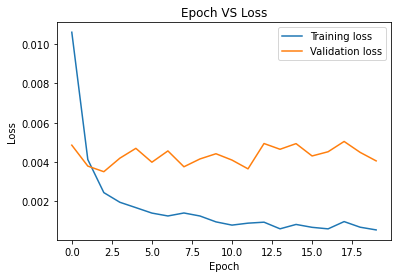

In [16]:
plt.plot(best_train_losses, label='Training loss')
plt.plot(best_val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Epoch VS Loss")
plt.legend()
plt.show()

# Plot of Accuracy on the Training and Validation Sets

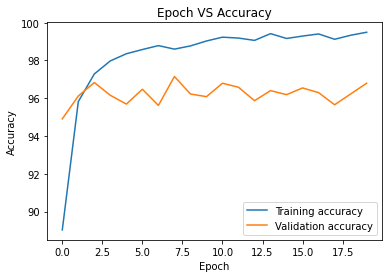

In [17]:
plt.plot(best_train_accs, label='Training accuracy')
plt.plot(best_val_accs, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Epoch VS Accuracy")
plt.legend()
plt.show()

# Calculate Recall for Each Class

In [18]:
true_labels = torch.tensor([])
pred_labels = torch.tensor([])

model.eval()
for i, data in enumerate(test_loader, 0):
    inputs, labels = data[0].to(device), data[1]
    outputs = model(inputs)
    preds = outputs.argmax(dim=1).cpu().detach()
    true_labels = torch.cat((true_labels, labels), dim=0)
    pred_labels = torch.cat((pred_labels, preds), dim=0)

cm = confusion_matrix(true_labels, pred_labels, labels=y_labels)

print('Recall for the various classes are:-\n')
for i in y_labels:
    label = labels_map[i]
    recall = cm[i][i] / cm[i].sum()
    print(f'{label} : {recall:.3f}')

Recall for the various classes are:-

AnnualCrop : 0.960
Forest : 0.995
HerbaceousVegetation : 0.975
Highway : 0.956
Industrial : 0.992
Pasture : 0.958
PermanentCrop : 0.912
Residential : 0.973
River : 0.972
SeaLake : 0.993


# Plot four examples the model got wrong and was most confident about

True: PermanentCrop
Predicted: HerbaceousVegetation
Prediction Probability: 1.000


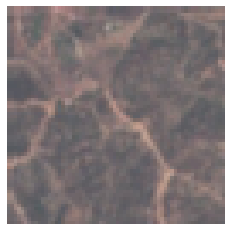



True: Highway
Predicted: PermanentCrop
Prediction Probability: 1.000


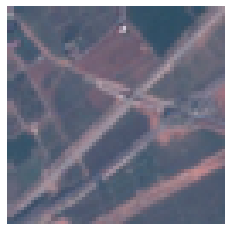



True: AnnualCrop
Predicted: Pasture
Prediction Probability: 0.999


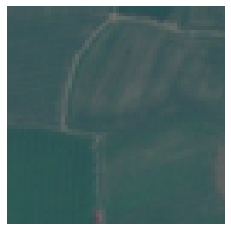



True: AnnualCrop
Predicted: SeaLake
Prediction Probability: 0.999


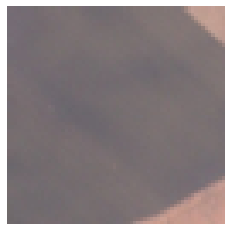

In [19]:
wrong_confident_preds = list()
softmax = nn.Softmax(dim=1)

model.eval()
for i, data in enumerate(test_loader, 0):
    inputs, labels = data[0].to(device), data[1]
    outputs = model(inputs)
    probs = softmax(outputs)
    preds = probs.argmax(dim=1).cpu().detach()
    for j in range(len(labels)):
        if labels[j] != preds[j]:
            prob = probs[j][preds[j]]
            if len(wrong_confident_preds) < 4:
                wrong_pred = {'image': data[0][j], 'true_class': labels[j], 'predicted_class': preds[j], 'prob': prob}
                wrong_confident_preds.append(wrong_pred)
            else:
                for k in range(4):
                    if prob > wrong_confident_preds[k]['prob']:
                        wrong_pred = {'image': data[0][j], 'true_class': labels[j], 'predicted_class': preds[j], 'prob': prob}
                        wrong_confident_preds[k] = wrong_pred
                        break

for prediction in wrong_confident_preds:
    print(f"True: {labels_map[prediction['true_class'].item()]}")
    print(f"Predicted: {labels_map[prediction['predicted_class'].item()]}")
    print(f"Prediction Probability: {prediction['prob']:.3f}")
    plt.axis("off")
    plt.imshow(prediction['image'].permute(1, 2, 0))
    plt.show()
    print()
    print()

# Store the Predictions in a File

In [20]:
with open('/kaggle/working/task2_predictions.csv', 'w') as f:
    f.write('id,label\n')
    for i in range(len(pred_labels)):
        f.write(f'{i},{int(pred_labels[i])}\n')